# Generalised Additive Model - analysis of relationship between DToCs and ED breaches

Imports

In [1]:
require(mgcv)
require(nlme)
require(car)
library(data.table)
library(ggplot2)

Loading required package: mgcv
Loading required package: nlme
This is mgcv 1.8-22. For overview type 'help("mgcv-package")'.
Loading required package: car


Read in and process data

In [2]:
#data = read.csv("input/20180913_diff_dtoc.csv")
dtoc = read.csv("input/dtoc.csv")

In [3]:
dtoc$yr = as.numeric(substr(dtoc$year, 1, 4))

In [4]:
head(dtoc)

year,month,total_atten,total_atten_t1,total_atten_.4hr,X95._targ,total_admissions,dtoc_a,dtoc_na,dtoc_total,mth,time,yr
2010-11,August,1719197,1138652,33184.00,0.9806980,425702.0,2559,2381,4940,8,1,2010
2010-11,September,1715117,1150728,41151.00,0.9760069,424900.0,2647,2357,5004,9,2,2010
2010-11,October,1753934,1163143,47414.00,0.9729671,436215.0,2513,2075,4588,10,3,2010
2010-11,November,1604591,1111295,46436.43,0.9710603,429099.0,2352,2057,4409,11,4,2010
2010-11,December,1647824,1159204,89917.29,0.9454327,452728.7,1995,1866,3861,12,5,2010
2010-11,January,1654907,1133881,72889.29,0.9559557,442003.7,2563,2034,4597,1,6,2010


Preliminary look at time series

In [5]:
ts_breach = ts(dtoc$total_atten_.4hr)
ts_dtoc = ts(dtoc$dtoc_total)
ts_attend = ts(dtoc$total_atten_t1)
ts_admit = ts(dtoc$total_admissions)

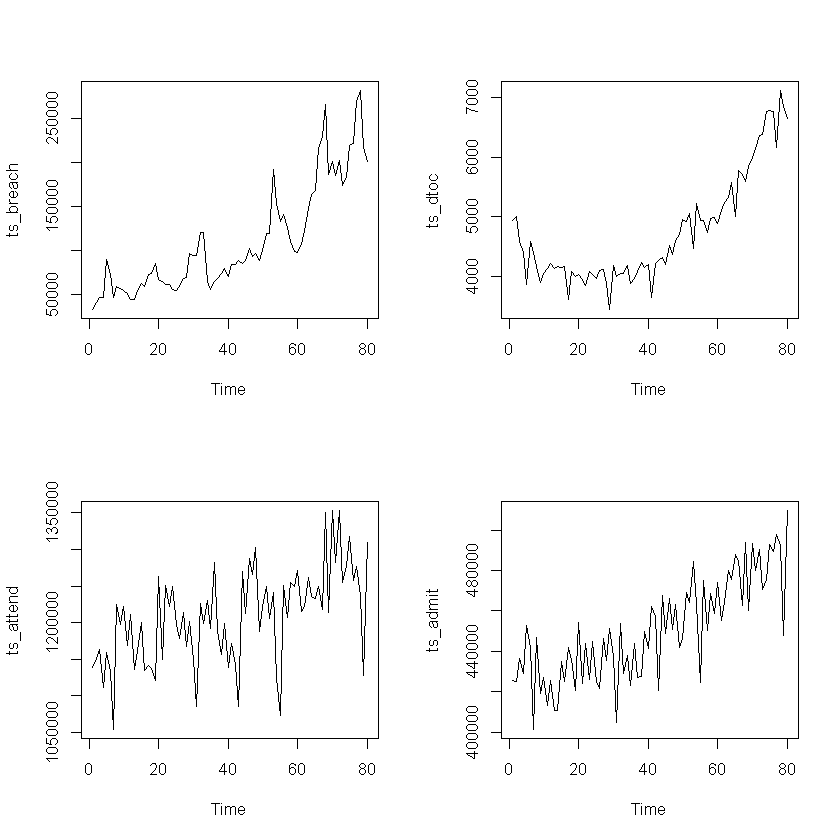

In [6]:
par(mfrow=c(2,2))
plot.ts(ts_breach,xy.lines=F,xy.labels=F) #  (increasing variance)
plot.ts(ts_dtoc,xy.lines=F,xy.labels=F)
plot.ts(ts_attend,xy.lines=F,xy.labels=F)
plot.ts(ts_admit,xy.lines=F,xy.labels=F)

## Utility functions

In [7]:
plot_fit <-function(gam, title){
    datas <- rbindlist(list(data.table(breaches = dtoc$total_atten_.4hr,time= dtoc$time),
    data.table(breaches = gam$fitted.values,time = dtoc$time)))

    datas[, type := c(rep("Real", nrow(dtoc)), rep("Fitted", nrow(dtoc)))]

    ggplot(data = datas, aes(time, breaches, group = type, colour = type)) +
      geom_line(size = 0.8) +
      theme_bw() +
      labs(x = "Time", y = "Breaches",
           title = paste("Fit from GAM",title))
    }

## Preliminary GAM models (not accounting for autocorrelation)

### Model 1: No interation between month and year 

In [8]:
m1 <- gamm(total_atten_.4hr ~s(mth, k = 12) + s(yr, k=6), data=dtoc)
summary(m1$gam)


Family: gaussian 
Link function: identity 

Formula:
total_atten_.4hr ~ s(mth, k = 12) + s(yr, k = 6)

Parametric coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)   110424       2464   44.81   <2e-16 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Approximate significance of smooth terms:
         edf Ref.df      F  p-value    
s(mth) 3.732  3.732  18.35 1.24e-10 ***
s(yr)  3.262  3.262 146.63  < 2e-16 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

R-sq.(adj) =  0.869   
  Scale est. = 4.7983e+08  n = 80

Take a look at month and year components.

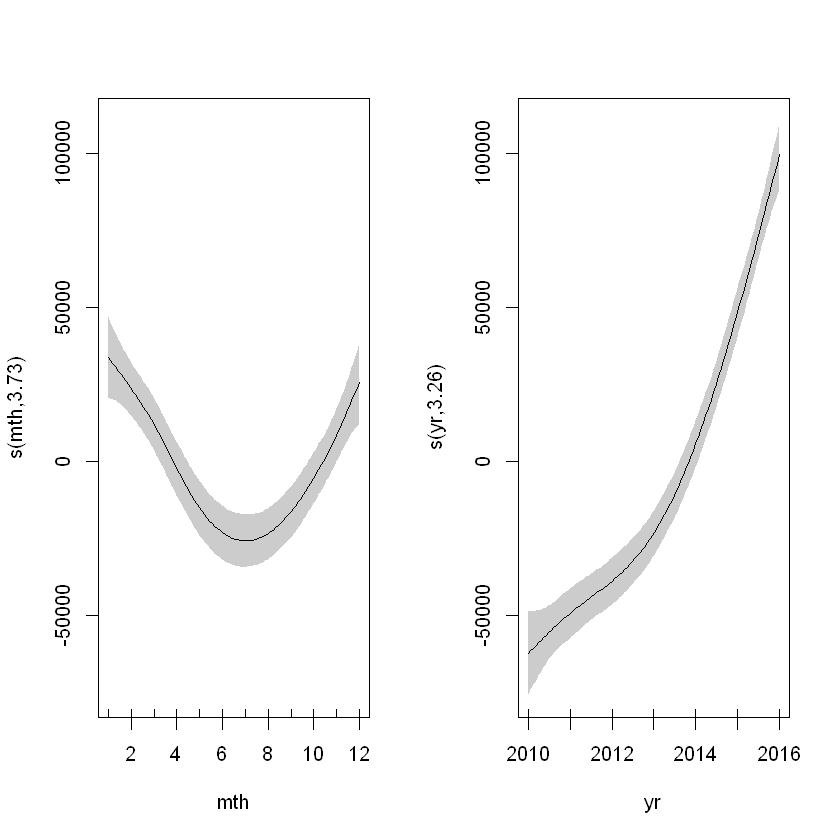

In [9]:
layout(matrix(1:2, nrow = 1))
plot(m1$gam, shade = TRUE)

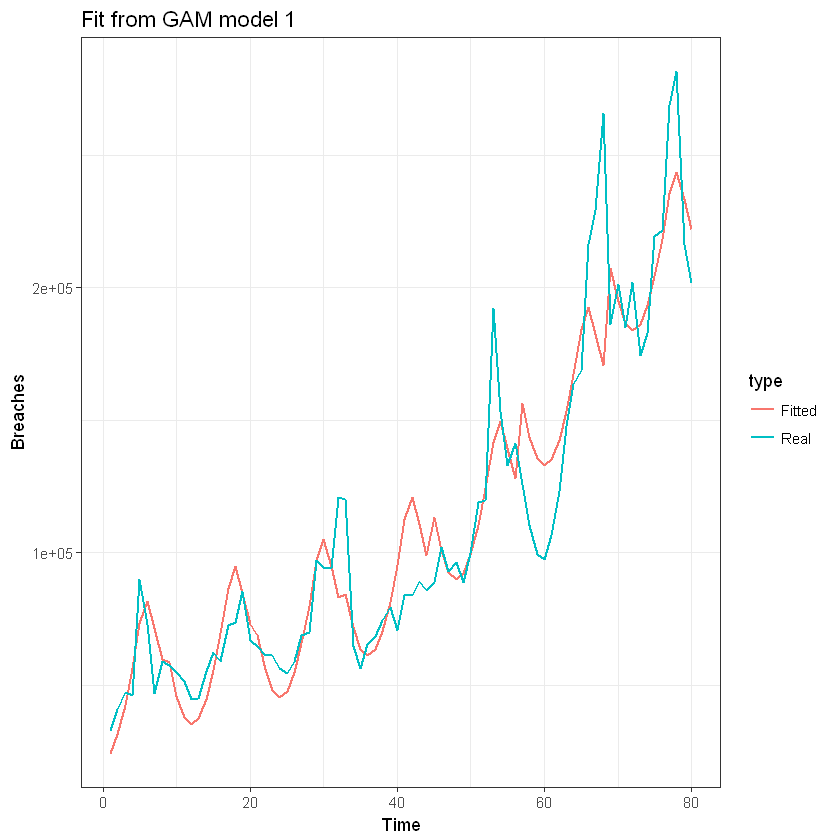

In [10]:
plot_fit(m1$gam, "model 1")

### Model 2: Month and Year Interaction (ignoring autocorrelation of resids)

In [11]:
m2 <- gamm(total_atten_.4hr ~s(mth, yr), data=dtoc)
summary(m2$gam)


Family: gaussian 
Link function: identity 

Formula:
total_atten_.4hr ~ s(mth, yr)

Parametric coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)   110424       2228   49.56   <2e-16 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Approximate significance of smooth terms:
            edf Ref.df     F p-value    
s(mth,yr) 15.71  15.71 42.48  <2e-16 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

R-sq.(adj) =  0.892   
  Scale est. = 3.922e+08  n = 80

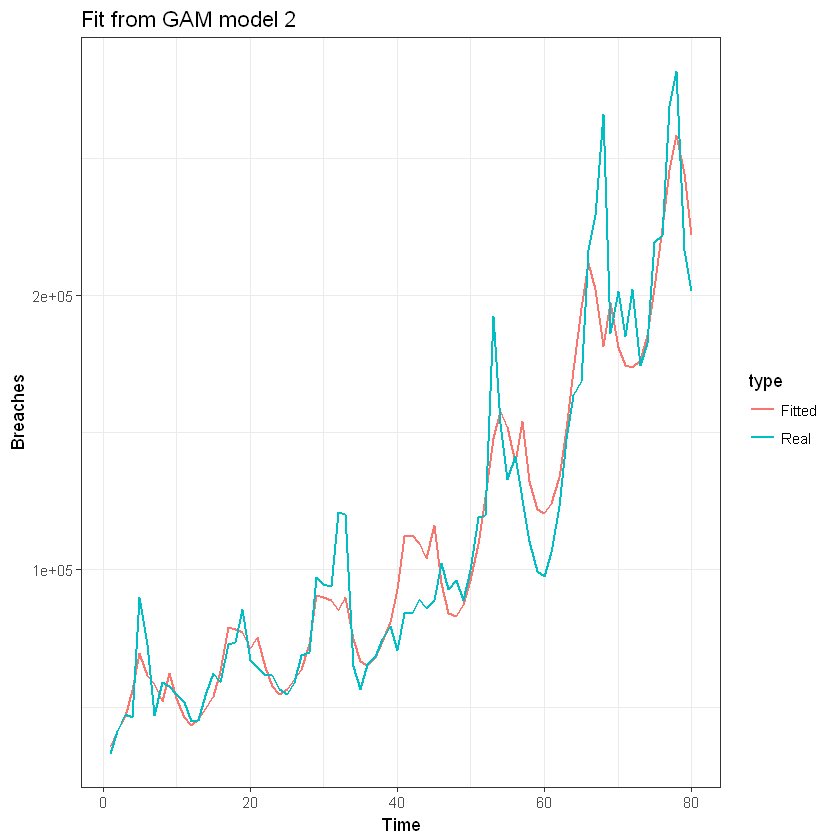

In [12]:
plot_fit(m2$gam, "model 2")

### Model 3: Tensor interactions(!?) (ignore errors)

In [13]:
m3 <- gamm(total_atten_.4hr ~ te(mth, yr, bs= c("cr", "ps")), data=dtoc)
summary(m3$gam)$r.sq

[1] 0.8946846

no real difference from splines

In [14]:
summary(m3$gam)$s.table

,edf,Ref.df,F,p-value
"te(mth,yr)",13.81033,13.81033,50.80815,9.118619e-88


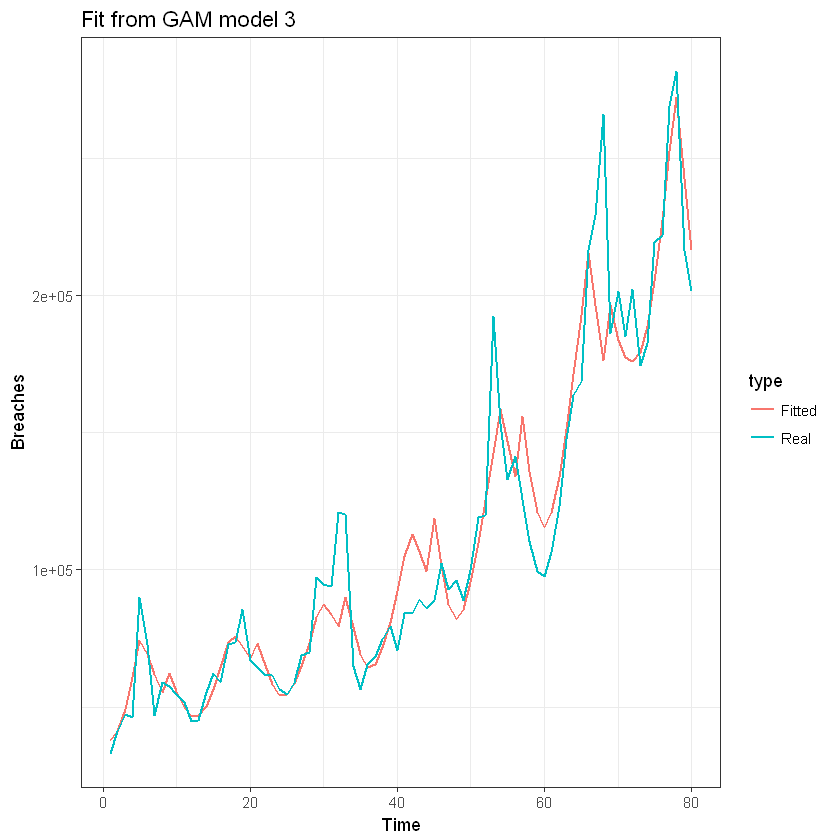

In [15]:
plot_fit(m3$gam, "model 3")

### Compare basic models

In [16]:
anova(m1$lme, m2$lme, m3$lme)

,call,Model,df,AIC,BIC,logLik,Test,L.Ratio,p-value
m1$lme,"lme.formula(fixed = y ~ X - 1, data = strip.offset(mf), random = rand, correlation = correlation, weights = weights, method = method, control = control)",1,6,1856.017,1870.309,-922.0083,,NA,NA
m2$lme,"lme.formula(fixed = y ~ X - 1, data = strip.offset(mf), random = rand, correlation = correlation, weights = weights, method = method, control = control)",2,5,1851.836,1863.746,-920.9181,1 vs 2,2.180418,0.139776460
m3$lme,"lme.formula(fixed = y ~ X - 1, data = strip.offset(mf), random = rand, correlation = correlation, weights = weights, method = method, control = control)",3,7,1845.349,1862.024,-915.6747,2 vs 3,10.486802,0.005282262


Conclusion - anova and AIC provide no strong evidence to go for interaction model over basic.  Visually it does look like we should be including an interaction between month and year!

## GAM - introducing further predictors (ignoring autocorrelation)

In [17]:
m4 <- gamm(total_atten_.4hr ~s(mth, k = 12) + s(yr, k=6) + dtoc_total, data=dtoc)
m5 <- gamm(total_atten_.4hr ~s(mth, k = 12) + s(yr, k=6) + s(dtoc_total, k = 6), data=dtoc)

In [18]:
summary(m5$gam)


Family: gaussian 
Link function: identity 

Formula:
total_atten_.4hr ~ s(mth, k = 12) + s(yr, k = 6) + s(dtoc_total, 
    k = 6)

Parametric coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)   110424       1947    56.7   <2e-16 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Approximate significance of smooth terms:
                edf Ref.df     F  p-value    
s(mth)        5.096  5.096 18.04 4.83e-13 ***
s(yr)         1.000  1.000 56.34 4.38e-11 ***
s(dtoc_total) 4.314  4.314 24.61 1.76e-15 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

R-sq.(adj) =  0.917   
  Scale est. = 2.9961e+08  n = 80

In [19]:
anova(m4$lme, m5$lme)

,call,Model,df,AIC,BIC,logLik,Test,L.Ratio,p-value
m4$lme,"lme.formula(fixed = y ~ X - 1, data = strip.offset(mf), random = rand, correlation = correlation, weights = weights, method = method, control = control)",1,7,1834.585,1851.259,-910.2924,,NA,NA
m5$lme,"lme.formula(fixed = y ~ X - 1, data = strip.offset(mf), random = rand, correlation = correlation, weights = weights, method = method, control = control)",2,8,1834.276,1853.332,-909.1378,1 vs 2,2.309271,0.1286043


no evidence to suggest using more complex model.

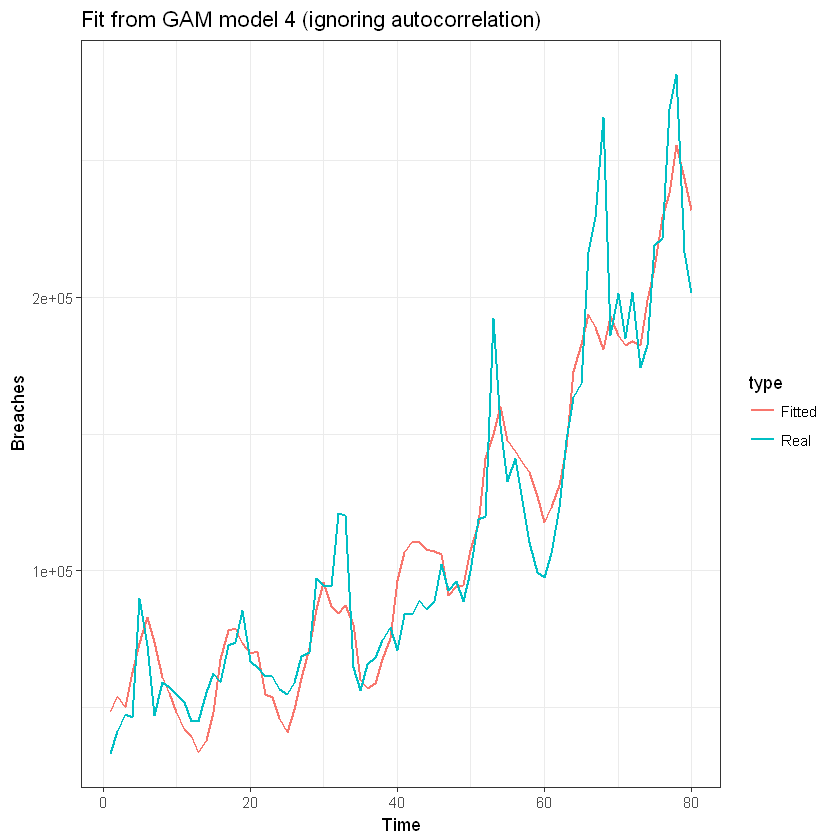

In [20]:
plot_fit(m4$gam, "model 4 (ignoring autocorrelation)")

In [21]:
m5 <- gamm(total_atten_.4hr ~s(mth, k = 12) + s(yr, k=6) 
           + dtoc_total 
           + total_admissions, 
           data=dtoc)

m6 <- gamm(total_atten_.4hr ~s(mth, k = 12) + s(yr, k=6) 
           + dtoc_total 
           + total_admissions
           + total_atten_t1, 
           data=dtoc)

In [22]:
anova(m4$lme, m5$lme, m6$lme)

,call,Model,df,AIC,BIC,logLik,Test,L.Ratio,p-value
m4$lme,"lme.formula(fixed = y ~ X - 1, data = strip.offset(mf), random = rand, correlation = correlation, weights = weights, method = method, control = control)",1,7,1834.585,1851.259,-910.2924,,NA,NA
m5$lme,"lme.formula(fixed = y ~ X - 1, data = strip.offset(mf), random = rand, correlation = correlation, weights = weights, method = method, control = control)",2,8,1831.859,1850.915,-907.9293,1 vs 2,4.726307,2.97046e-02
m6$lme,"lme.formula(fixed = y ~ X - 1, data = strip.offset(mf), random = rand, correlation = correlation, weights = weights, method = method, control = control)",3,9,1804.909,1826.347,-893.4543,2 vs 3,28.950053,7.42688e-08


In [23]:
summary(m6$gam)


Family: gaussian 
Link function: identity 

Formula:
total_atten_.4hr ~ s(mth, k = 12) + s(yr, k = 6) + dtoc_total + 
    total_admissions + total_atten_t1

Parametric coefficients:
                   Estimate Std. Error t value Pr(>|t|)    
(Intercept)      -1.897e+05  5.778e+04  -3.283 0.001620 ** 
dtoc_total        3.914e+01  3.799e+00  10.302 1.49e-15 ***
total_admissions -1.113e+00  2.777e-01  -4.009 0.000153 ***
total_atten_t1    5.100e-01  8.480e-02   6.014 7.91e-08 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Approximate significance of smooth terms:
         edf Ref.df     F  p-value    
s(mth) 6.582  6.582 18.38 8.57e-16 ***
s(yr)  1.000  1.000 59.36 1.57e-11 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

R-sq.(adj) =  0.933   
  Scale est. = 2.3251e+08  n = 80

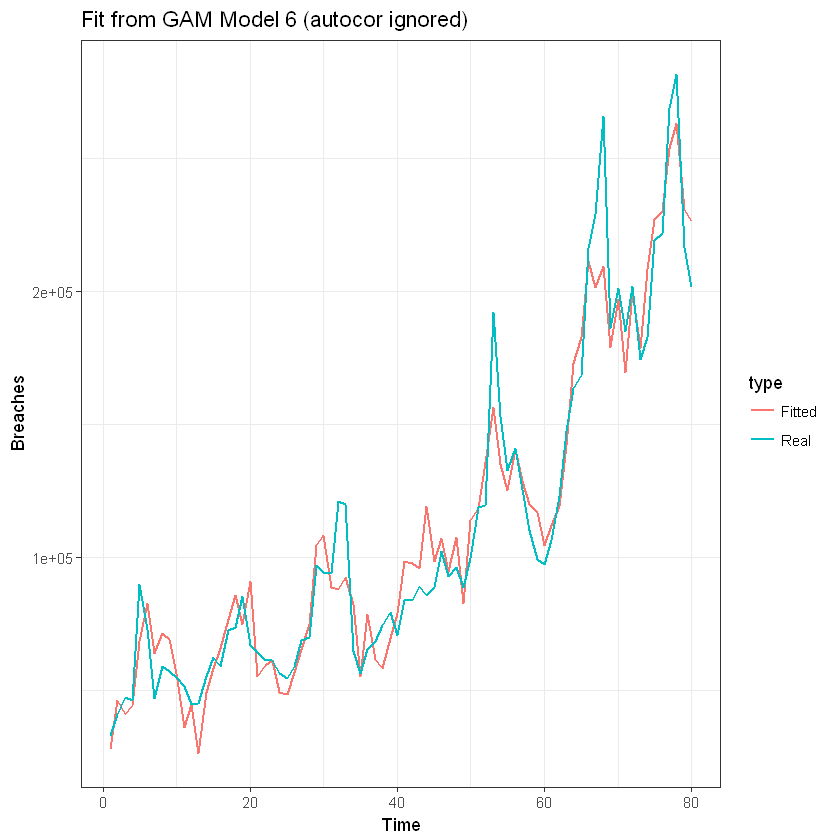

In [24]:
plot_fit(m6$gam, "Model 6 (autocor ignored)")

## GAM - modelling autocorrelation in residuals

Starting from model 6

In [43]:
m6 <- gamm(total_atten_.4hr ~s(mth, k = 12) + s(yr, k=6) 
           + dtoc_total 
           + total_admissions
           + total_atten_t1, 
           data=dtoc)

m6_p1 <- gamm(total_atten_.4hr ~s(mth, k = 6) + s(yr, k=6) 
           + dtoc_total 
           + total_admissions
           + total_atten_t1, 
           data=dtoc,
           correlation = corARMA(form = ~ 1|yr, p = 1))


m6_p2 <- gamm(total_atten_.4hr ~s(mth, k = 12) + s(yr, k=6) 
           + dtoc_total 
           + total_admissions
           + total_atten_t1, 
           data=dtoc,
           correlation = corARMA(form = ~ 1|yr, p = 2))


In [44]:
anova(m6$lme, m6_p1$lme, m6_p2$lme)

,call,Model,df,AIC,BIC,logLik,Test,L.Ratio,p-value
m6$lme,"lme.formula(fixed = y ~ X - 1, data = strip.offset(mf), random = rand, correlation = correlation, weights = weights, method = method, control = control)",1,9,1804.909,1826.347,-893.4543,,NA,NA
m6_p1$lme,"lme.formula(fixed = y ~ X - 1, data = strip.offset(mf), random = rand, correlation = correlation, weights = weights, method = method, control = control)",2,10,1798.726,1822.546,-889.3630,1 vs 2,8.1824421,0.004229778
m6_p2$lme,"lme.formula(fixed = y ~ X - 1, data = strip.offset(mf), random = rand, correlation = correlation, weights = weights, method = method, control = control)",3,11,1799.736,1825.939,-888.8681,2 vs 3,0.9897891,0.319793927


Conclusion - AR(1) has small, but sig improvement in AIC and BIC.

In [45]:
summary(m6_p1$gam)


Family: gaussian 
Link function: identity 

Formula:
total_atten_.4hr ~ s(mth, k = 6) + s(yr, k = 6) + dtoc_total + 
    total_admissions + total_atten_t1

Parametric coefficients:
                   Estimate Std. Error t value Pr(>|t|)    
(Intercept)      -1.779e+05  4.877e+04  -3.648 0.000503 ***
dtoc_total        3.263e+01  5.320e+00   6.133 4.47e-08 ***
total_admissions -7.933e-01  2.902e-01  -2.734 0.007917 ** 
total_atten_t1    4.066e-01  9.208e-02   4.416 3.56e-05 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Approximate significance of smooth terms:
         edf Ref.df     F  p-value    
s(mth) 4.551  4.551 16.50 1.27e-10 ***
s(yr)  1.000  1.000 39.28 1.62e-08 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

R-sq.(adj) =  0.929   
  Scale est. = 2.6633e+08  n = 80

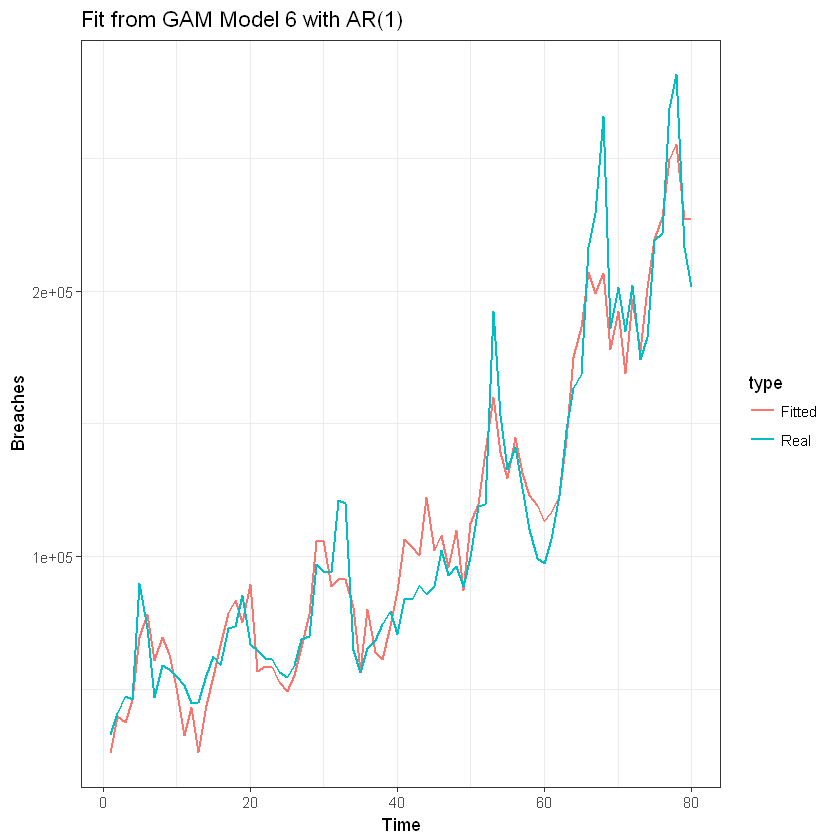

In [46]:
plot_fit(m6_p1$gam, "Model 6 with AR(1)")

### Diagnostics of Model 6 with AR(1)

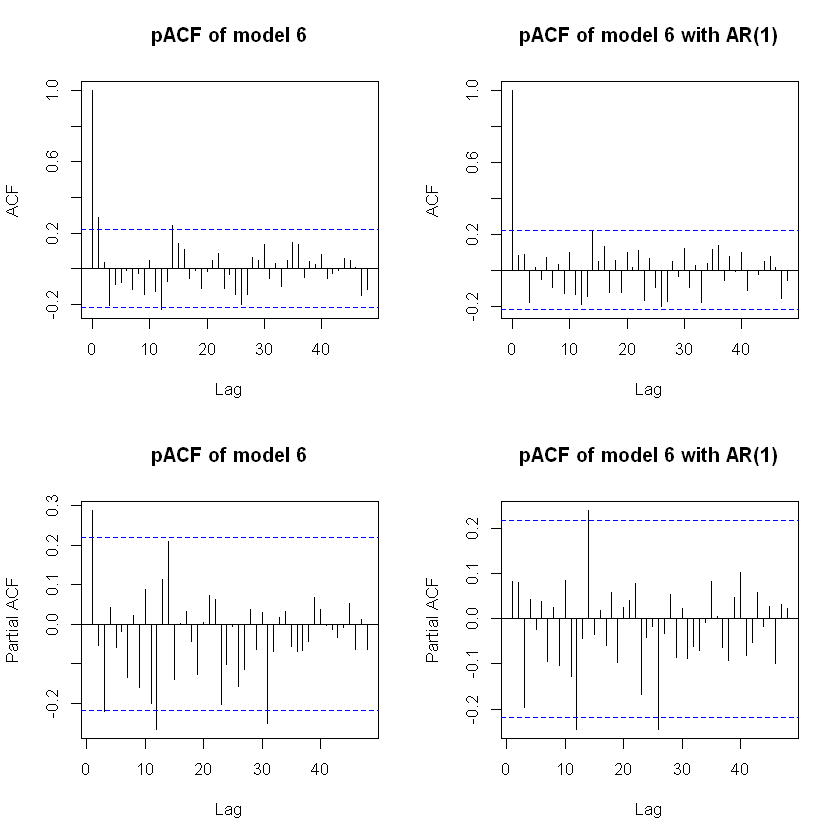

In [47]:
par(mfrow=c(2,2))
acf(resid(m6$lme, type = "normalized"), lag.max = 48, main = "pACF of model 6")
acf(resid(m6_p1$lme, type = "normalized"), lag.max = 48, main = "pACF of model 6 with AR(1)")
pacf(resid(m6$lme, type = "normalized"), lag.max = 48, main = "pACF of model 6")
pacf(resid(m6_p1$lme, type = "normalized"), lag.max = 48, main = "pACF of model 6 with AR(1)")


In [30]:
arma_res <- auto.arima(resid(m6$lme, type = "normalized"),
                       stationary = TRUE, seasonal = TRUE)
 
arma_res$coef

ERROR: Error in auto.arima(resid(m6$lme, type = "normalized"), stationary = TRUE, : could not find function "auto.arima"
